# 04_lmu_dms

This notebook shows how to implement the delayed match-to-sample task using an LMU.

In [ ]:
#default_exp lmu

In [ ]:
#@title Environment Setup
try:
    # See if we are running on google.colab
    from google.colab import files
    IN_COLAB = True
    !pip install --upgrade nengo nengo-gui nbdev git+https://github.com/neuromorphs/grill-srnn-pfc.git
    !jupyter serverextension enable nengo_gui.jupyter
    # TODO: kaggle creds for downloading data 
    
except ModuleNotFoundError:
    IN_COLAB = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Input Setup

We use the srnn_pfc library to generate the stimulus data and desired target.
Here's what those signals look like:

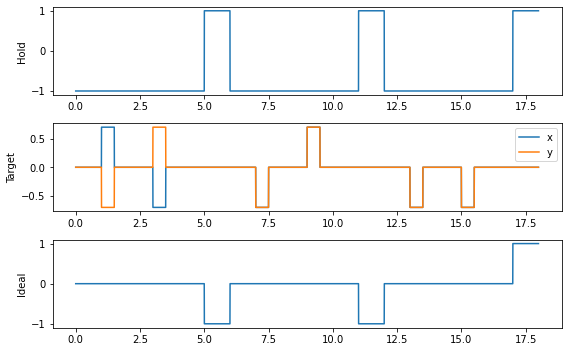

In [ ]:
from srnn_pfc.dms import DMSTask

DMSTask().plot_inputs()

## Legendre Memory Unit

Now we need to build a network that takes the Target as input and outputs the Ideal value.

We'll do this with an [LMU (Legendre Memory Unit)](https://github.com/abr/lmu). The standard way to express an LMU is a linear "Legendre Delay Network" (LDN) followed by a standard neural network non-linear layer. There are optional connections between the LDN and the non-linear layer, but let's be very simple and just have a purely feed-forward system.  The only recurrence in this version is in the linear LDN.  (Note: later in this notebook we'll move the recurrence to the neurons so that it's just one recurrent network doing everything)

Here's a quick implementation of the LDN using a Nengo [`Process`](https://www.nengo.ai/nengo/examples/advanced/processes.html), which is a slightly fancier way of configuring a `Node`.

In [ ]:
#export
import numpy as np
import nengo
import scipy.linalg


class LDN(nengo.Process):
    def __init__(self, theta, q, size_in=1):
        self.q = q              # number of internal state dimensions per input
        self.theta = theta      # size of time window (in seconds)
        self.size_in = size_in  # number of inputs

        # Do Aaron's math to generate the matrices
        #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
        Q = np.arange(q, dtype=np.float64)
        R = (2*Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        self.A = np.where(i < j, -1, (-1.)**(i-j+1)) * R
        self.B = (-1.)**Q[:, None] * R

        super().__init__(default_size_in=size_in, default_size_out=q*size_in)

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        state = np.zeros((self.q, self.size_in))

        # Handle the fact that we're discretizing the time step
        #  https://en.wikipedia.org/wiki/Discretization#Discretization_of_linear_state_space_models
        Ad = scipy.linalg.expm(self.A*dt)
        Bd = np.dot(np.dot(np.linalg.inv(self.A), (Ad-np.eye(self.q))), self.B)

        # this code will be called every timestep
        def step_legendre(t, x, state=state):
            state[:] = np.dot(Ad, state) + np.dot(Bd, x[None, :])
            return state.T.flatten()
        return step_legendre


## Model 1: Purely Feed-forward

In [ ]:
from srnn_pfc.dms import DMSTask


def make_ff_lmu_net(theta=6.0, q=6, n_neurons=3000, seed=1337,
                    out_transform=None,
                    n_trials_per_cond=5, trial_seed=1337):
    dms = DMSTask(gen_trials_per_cond=n_trials_per_cond, cond_seed=trial_seed)
    
    model = nengo.Network()
    with model:
        # Feedforward: targets --> ldn --> ensemble
        stim = nengo.Node(dms.stim_signal)
        ldn = nengo.Node(LDN(theta=theta, q=q, size_in=2))
        nengo.Connection(stim, ldn, synapse=None)
        ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=ldn.output.q*2, seed=seed)
        nengo.Connection(ldn, ens)
        
        # Grab a dim=1 output
        output = nengo.Node(None, size_in=1)
        if out_transform is None:
            out_transform = np.ones((1, ens.n_neurons))
        nengo.Connection(ens.neurons, output,
                         transform=out_transform)
        
        # Sim the 'ideal' signal.
        ideal = nengo.Node(dms.ideal_signal)
        
        # Capture the output
        probes = {
            'ensemble': nengo.Probe(ens.neurons),
            'output': nengo.Probe(output),
            'ideal': nengo.Probe(ideal)
        }
    return model, probes

### Offline Training

Now we run our network for a while, recording the data from the neurons.

In [ ]:
train_per_cond = 3
train_seed = 1337
model, probes = make_ff_lmu_net(n_trials_per_cond=train_per_cond,
                                trial_seed=train_seed)
sim = nengo.Simulator(model)
sim.run(6 * 8 * train_per_cond)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

We use the simulated data to compute decoders for the output we want using L2-regularized least squares regression. Solve for $D$ in $AD=Y$, where $Y$ is the (filtered) ideal response, $A$ is the (filtered) ensemble activity, and $D$ is the decoder matrix.

As there is a lot of data here, we use an iterative least-squares solver from scipy, which should run faster than the default solver for this case.

In [ ]:
filt = nengo.synapses.Lowpass(0.01)
A = filt.filt(sim.data[probes['ensemble']])
Y = filt.filt(sim.data[probes['ideal']])

import nengo.utils.least_squares_solvers as lss
D, info = nengo.solvers.LstsqL2(solver=lss.LSMRScipy())(A, Y)

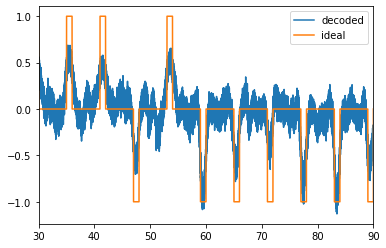

In [ ]:
import matplotlib.pyplot as plt

train_decoded = A.dot(D)
train_ideal = sim.data[probes['ideal']]
train_tvec = sim.trange()
plt.plot(train_tvec, train_decoded, label='decoded')
plt.plot(train_tvec, train_ideal, label='ideal')
plt.legend()
plt.xlim([30, 90])
plt.show()

### Online Testing

That seems like a pretty good decoder. Let's build our network again, using that decoder, but with a new set of trials.

In [ ]:
test_per_cond = 3
test_seed = 1234
model, probes = make_ff_lmu_net(out_transform=D.T,
                                n_trials_per_cond=test_per_cond,
                                trial_seed=test_seed)
sim = nengo.Simulator(model)
sim.run(6 * 16 * test_per_cond)  # 6 seconds per trial, 16 conditions

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

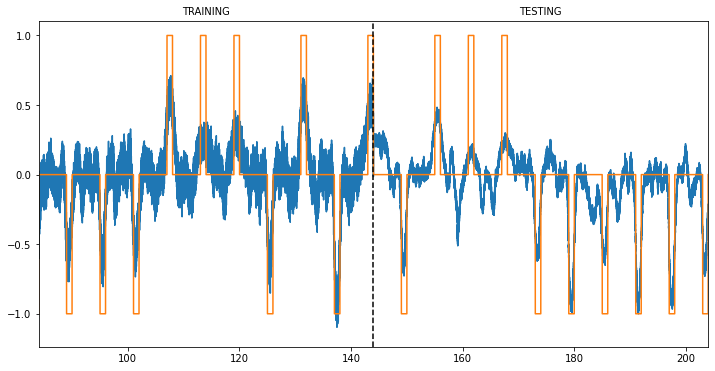

In [ ]:
test_output = filt.filt(sim.data[probes['output']])
test_ideal = sim.data[probes['ideal']]
test_tvec = sim.trange()

tvec = np.hstack((train_tvec, train_tvec[-1] + np.median(np.diff(test_tvec)) + test_tvec))

plt.figure(figsize=(12, 6))
plt.plot(tvec, np.vstack((train_decoded, test_output)))
plt.plot(tvec, np.vstack((train_ideal, test_ideal)))
plt.axvline(train_tvec[-1], ls='--', color='k')
plt.text(train_tvec[-1] - 30, 1.15, 'TRAINING', ha='center')
plt.text(train_tvec[-1] + 30, 1.15, 'TESTING', ha='center')
plt.xlim(train_tvec[-1] - 60, train_tvec[-1] + 60)
plt.show()

Awesome! That seems to generalize pretty well.

More training examples might help, but it's still doing a pretty good job. We might want to try seeing how varying the number of neurons in the non-linearity affects things. There's also the `q` parameter in the LDN to vary.

## Model 2: LDN in RNN

However, there's another big change we might want to make. With the network as defined above, the recurrence is not done with neurons. It's just done in math, with this simple linear calculation happening before the neurons. This may be what we want to do if we're just interested in efficiency on traditional hardware. But, we can also re-organize our network such that we recurrently connect the neurons to approximate the differential equation of the LDN. We do this using the [NEF trick](http://compneuro.uwaterloo.ca/files/publications/stewart.2012d.pdf) for approximating any differential equation using neurons. Importantly, we can then use those exact same neurons for the readout, so we only have one group of neurons in our final model.

The basic LDN differential equation is ${{dm} \over {dt}} = Am+Bu$ and the LDN code above computes those $A$ and $B$ matrices for us.  However, those matrices are for the case of 1 dimensional input.  In this case we actually have 2 dimensions being input, and the LDN just treats that as two separate LDNs.  If we want to write all of that as one giant differential equation of $2q$ dimensions, then we need to make new A and B matrices that just have copies of the old A and B matrices along the diagonal.

In [ ]:
#export

def make_ldn_B_A(theta=6.0, q=6, size_in=2):
    ldn = LDN(theta=theta, q=q, size_in=2)
    B_full = np.zeros((ldn.q*size_in, size_in))
    A_full = np.zeros((ldn.q*size_in, ldn.q*size_in))
    for i in range(size_in):
        B_full[ldn.q*i:ldn.q*(i+1), i:i+1] = ldn.B
        A_full[ldn.q*i:ldn.q*(i+1), ldn.q*i:ldn.q*(i+1)] = ldn.A
    
    return ldn, B_full, A_full


Text(0.5, 1.0, 'A Full')

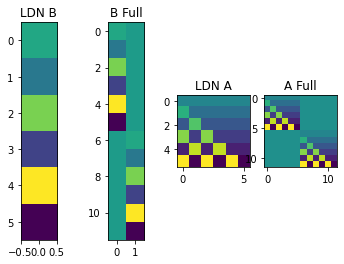

In [ ]:
ldn, B_full, A_full = make_ldn_B_A()

plt.subplot(1, 4, 1)
plt.imshow(ldn.B)
plt.title('LDN B')

plt.subplot(1, 4, 2)
plt.imshow(B_full)
plt.title('B Full')

plt.subplot(1, 4, 3)
plt.imshow(ldn.A)
plt.title('LDN A')

plt.subplot(1, 4, 4)
plt.imshow(A_full)
plt.title('A Full')

Now we define our neural network with just one recurrence, and we use the NEF trick of computing $\tau g(u)$ on the input and $\tau f(x)+x$ on the recurrent connection to give a resulting network that approximates ${{dx} \over {dt}} = f(x)+g(u)$.

In the ideal case, we could just use the decoders that we've previously computed to use with this network.  However, it's only going to be approximating that differential equation, and so any differences may change the result.  So let's re-do the training.

In [ ]:
#export
from srnn_pfc.dms import DMSTask


def make_lmu_dms(theta=6.0, q=6, n_neurons=3000, seed=1337,
                 out_transform=None,
                 n_trials_per_cond=5, trial_seed=1337,
                 tau=0.1):
    """
    Make a LMU network that performs the delayed match to sample task.
    returns the model and a dictionary of the probes.
    """
    ldn, B_full, A_full = make_ldn_B_A(theta=theta, q=q, size_in=2)    
    dms = DMSTask(gen_trials_per_cond=n_trials_per_cond, cond_seed=trial_seed)
    
    model = nengo.Network()
    with model:
        stim = nengo.Node(dms.stim_signal)
        
        ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=ldn.q*2, seed=seed)
        
        nengo.Connection(stim, ens, transform=B_full*tau, synapse=tau)
        nengo.Connection(ens, ens, synapse=tau, transform=A_full*tau+np.eye(ldn.q*2))
        
        output = nengo.Node(None, size_in=1)
        if out_transform is None:
            out_transform = np.ones((1, ens.n_neurons))
        nengo.Connection(ens.neurons, output,
                         transform=out_transform)
        
        # Sim the 'ideal' signal.
        ideal = nengo.Node(dms.ideal_signal)
        
        # Capture the output
        probes = {
            'ensemble': nengo.Probe(ens.neurons),
            'output': nengo.Probe(output),
            'ideal': nengo.Probe(ideal)
        }
    return model, probes


### Offline Training

In [ ]:
train_per_cond = 3
train_seed = 1337
model, probes = make_lmu_dms(n_trials_per_cond=train_per_cond,
                             trial_seed=train_seed)
with nengo.Simulator(model) as sim:
    sim.run(6 * 16 * test_per_cond)  # 6 seconds per trial, 16 conditions

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [ ]:
filt = nengo.synapses.Lowpass(0.01)
A = filt.filt(sim.data[probes['ensemble']])
Y = filt.filt(sim.data[probes['ideal']])

import nengo.utils.least_squares_solvers as lss
D, info = nengo.solvers.LstsqL2(solver=lss.LSMRScipy())(A, Y)

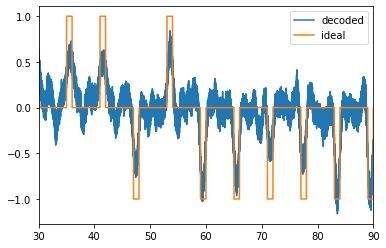

In [ ]:
train_tvec = sim.trange()
train_decoded = A.dot(D)
train_ideal = sim.data[probes['ideal']]

plt.plot(train_tvec, train_decoded, label='decoded')
plt.plot(train_tvec, train_ideal, label='ideal')
plt.legend()
plt.xlim([30, 90])
plt.show()

### Online Testing

And let's see how the resulting network generalizes.

In [ ]:
test_per_cond = 3
test_seed = 1234
model, probes = make_ff_lmu_net(out_transform=D.T,
                                n_trials_per_cond=test_per_cond,
                                trial_seed=test_seed)
with nengo.Simulator(model) as sim:
    sim.run(6 * 16 * test_per_cond)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

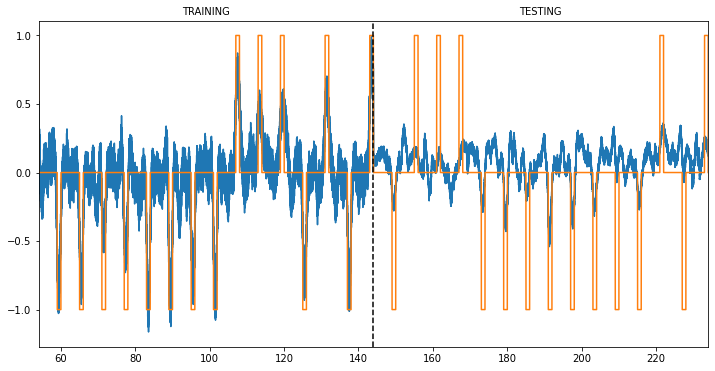

In [ ]:
test_output = filt.filt(sim.data[probes['output']])
test_ideal = sim.data[probes['ideal']]
test_tvec = sim.trange()

tvec = np.hstack((train_tvec, train_tvec[-1] + np.median(np.diff(test_tvec)) + test_tvec))

plt.figure(figsize=(12,6))
plt.plot(tvec, np.vstack((train_decoded, test_output)))
plt.plot(tvec, np.vstack((train_ideal, test_ideal)))
plt.axvline(train_tvec[-1], ls='--', color='k')
plt.text(train_tvec[-1] - 45, 1.15, 'TRAINING', ha='center')
plt.text(train_tvec[-1] + 45, 1.15, 'TESTING', ha='center')
plt.xlim(train_tvec[-1] - 90, train_tvec[-1] + 90)
plt.show()

It's not quite as good, but we'd need to do more testing to see if that's a statistically significant difference.  We should also consider whether we need to adjust the radius of the ensemble, to make sure aren't going outside that range.  

We could also look at adjusting the task the network needs to compute a bit.  In this case, the network is trying to learn everything about the task, including when to produce the answer.  For example, if some other (hand-designed) network was responsible for gating the output so that it only responds when it is supposed to, then we could adjust the training to only the points where the output is given (i.e. it's just trying to match the +1 and -1 outputs, not also trying to produce 0 the rest of the time).  This should be easier to do.